# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    # resize and normalize the images
    transform=transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()]) #resize to 64X64
    
    # get the data path
    image_path = './' + data_dir
    
    # define datasets using ImageFolder
    dataset=datasets.ImageFolder(image_path,transform)
    
    # create and return DataLoaders
    dataloader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)
    
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

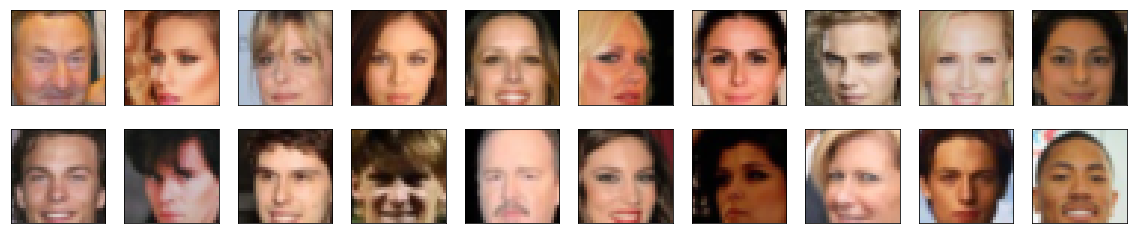

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min,max=feature_range
    x=x*(max-min)+min
    
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[5]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.8745)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim=conv_dim
        
        #32X32 input
        self.conv1=conv(3,conv_dim,4,batch_norm=False) #x,y=16,depth=64
        #16X16 output (32-2(F))/2 stride +1
        self.conv2=conv(conv_dim,conv_dim*2,4) #(8,8,128)
        #8X8 output
        self.conv3=conv(conv_dim*2,conv_dim*4,4) #(4,4,256)
        #4X4 output
        
        # final, fully-connected layer
        self.fc=nn.Linear(conv_dim*4*4*4,1)
        
        #classification layer
        #self.conv4=conv(conv_dim*4,1,4,stride=1,batch_norm=False)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out=F.leaky_relu(self.conv1(x),0.2)
        out=F.leaky_relu(self.conv2(out),0.2)
        out=F.leaky_relu(self.conv3(out),0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out=self.fc(out)
       
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(transpose_conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim=conv_dim
        
        # first, fully_connected layer
        self.fc=nn.Linear(z_size, conv_dim*8*2*2)
        #32X32 input
        self.t_conv1=deconv(conv_dim*8,conv_dim*4,4)
        #16X16 out
        self.t_conv2=deconv(conv_dim*4,conv_dim*2,4)
        #8X8 out
        self.t_conv3=deconv(conv_dim*2,conv_dim,4) 
        #4X4 out
        #self.t_conv4=deconv(conv_dim*2,conv_dim,4)
        
        self.t_conv4=deconv(conv_dim,3,4,batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out=self.fc(x)
        out=out.view(-1,self.conv_dim*8,2,2) # (batch_size,depth)
        
        # hidden transpose conv layers + relu
        out=F.relu(self.t_conv1(out))
        out=F.relu(self.t_conv2(out))
        out=F.relu(self.t_conv3(out))
        
        
        # last layer + tanh activation
        ######################## need work
        out=self.t_conv4(out)
        out=F.tanh(out)   
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # The bias terms, if they exist, set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_() 
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
import tensorflow as tf
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size=D_out.size(0)
    
    #if smooth:
        # smooth, real labels = 0.9
        #labels = torch.ones(batch_size)*0.9
    #else:
    labels = torch.ones(batch_size)*.9 # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr=0.0002
beta1=0.5
beta2=0.999
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # 1.1 Train with real images
            
            # Compute the discriminator losses on real images
            if train_on_gpu:
                real_images=real_images.cuda()
                
            D_real=D(real_images)
            d_real_loss = real_loss(D_real)
            
            #1.2 Train with fake images
            
            # Generate fake images
            z=np.random.uniform(-1,1,size=(batch_size,z_size))
            z=torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z=z.cuda()
            fake_images=G(z)
            
            # Compute the discriminator losses on fake images
            D_fake=D(fake_images)
            d_fake_loss=fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss+d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
        
            # 2.1 Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.2997 | g_loss: 1.2454
Epoch [    1/   30] | d_loss: 0.4995 | g_loss: 3.1942
Epoch [    1/   30] | d_loss: 0.5640 | g_loss: 2.5495
Epoch [    1/   30] | d_loss: 0.5504 | g_loss: 2.8633
Epoch [    1/   30] | d_loss: 0.5839 | g_loss: 2.3156
Epoch [    1/   30] | d_loss: 0.8181 | g_loss: 1.5738
Epoch [    1/   30] | d_loss: 0.8648 | g_loss: 2.8683
Epoch [    1/   30] | d_loss: 0.8080 | g_loss: 1.8814
Epoch [    1/   30] | d_loss: 0.7749 | g_loss: 2.8755
Epoch [    1/   30] | d_loss: 0.8713 | g_loss: 3.0316
Epoch [    1/   30] | d_loss: 0.8775 | g_loss: 1.9031
Epoch [    1/   30] | d_loss: 0.9765 | g_loss: 1.3867
Epoch [    1/   30] | d_loss: 0.8329 | g_loss: 2.7482
Epoch [    1/   30] | d_loss: 1.1080 | g_loss: 1.7554
Epoch [    1/   30] | d_loss: 0.9369 | g_loss: 1.6906
Epoch [    1/   30] | d_loss: 0.9842 | g_loss: 1.4097
Epoch [    1/   30] | d_loss: 0.9980 | g_loss: 1.8251
Epoch [    1/   30] | d_loss: 0.9829 | g_loss: 1.7573
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 1.1826 | g_loss: 1.3606
Epoch [    3/   30] | d_loss: 1.0951 | g_loss: 1.3914
Epoch [    3/   30] | d_loss: 1.4436 | g_loss: 1.9613
Epoch [    3/   30] | d_loss: 0.8807 | g_loss: 1.8116
Epoch [    3/   30] | d_loss: 1.0321 | g_loss: 1.7314
Epoch [    3/   30] | d_loss: 1.0315 | g_loss: 1.5937
Epoch [    3/   30] | d_loss: 1.4330 | g_loss: 0.5358
Epoch [    3/   30] | d_loss: 1.3057 | g_loss: 1.6023
Epoch [    3/   30] | d_loss: 1.2936 | g_loss: 0.9395
Epoch [    3/   30] | d_loss: 1.0816 | g_loss: 1.1847
Epoch [    3/   30] | d_loss: 0.8334 | g_loss: 2.2989
Epoch [    3/   30] | d_loss: 0.8915 | g_loss: 1.1098
Epoch [    3/   30] | d_loss: 1.3410 | g_loss: 1.7542
Epoch [    3/   30] | d_loss: 1.2604 | g_loss: 1.5280
Epoch [    3/   30] | d_loss: 1.0448 | g_loss: 1.2001
Epoch [    3/   30] | d_loss: 1.1269 | g_loss: 1.0913
Epoch [    3/   30] | d_loss: 1.1352 | g_loss: 1.1257
Epoch [    3/   30] | d_loss: 1.0235 | g_loss: 0.8250
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 1.1107 | g_loss: 1.6260
Epoch [    6/   30] | d_loss: 1.0816 | g_loss: 1.3443
Epoch [    6/   30] | d_loss: 1.1813 | g_loss: 1.9059
Epoch [    6/   30] | d_loss: 1.0211 | g_loss: 1.9118
Epoch [    6/   30] | d_loss: 0.8854 | g_loss: 1.5618
Epoch [    6/   30] | d_loss: 1.3595 | g_loss: 1.1061
Epoch [    6/   30] | d_loss: 0.8869 | g_loss: 1.7277
Epoch [    6/   30] | d_loss: 1.0857 | g_loss: 1.9159
Epoch [    6/   30] | d_loss: 1.2279 | g_loss: 1.6072
Epoch [    6/   30] | d_loss: 0.8664 | g_loss: 1.4781
Epoch [    6/   30] | d_loss: 1.0246 | g_loss: 1.5928
Epoch [    6/   30] | d_loss: 0.9495 | g_loss: 1.0229
Epoch [    6/   30] | d_loss: 1.0868 | g_loss: 1.1350
Epoch [    6/   30] | d_loss: 1.0950 | g_loss: 0.9275
Epoch [    6/   30] | d_loss: 0.9631 | g_loss: 1.5787
Epoch [    6/   30] | d_loss: 1.1472 | g_loss: 1.2018
Epoch [    6/   30] | d_loss: 0.8395 | g_loss: 1.6305
Epoch [    6/   30] | d_loss: 0.9103 | g_loss: 1.6199
Epoch [    6/   30] | d_loss

Epoch [    9/   30] | d_loss: 0.9645 | g_loss: 1.8357
Epoch [    9/   30] | d_loss: 0.7486 | g_loss: 1.1499
Epoch [    9/   30] | d_loss: 1.0047 | g_loss: 2.0942
Epoch [    9/   30] | d_loss: 0.6772 | g_loss: 2.4214
Epoch [    9/   30] | d_loss: 0.8246 | g_loss: 1.3946
Epoch [    9/   30] | d_loss: 0.6537 | g_loss: 1.8582
Epoch [    9/   30] | d_loss: 1.0345 | g_loss: 2.4247
Epoch [    9/   30] | d_loss: 0.8536 | g_loss: 1.5346
Epoch [    9/   30] | d_loss: 0.9194 | g_loss: 1.5813
Epoch [    9/   30] | d_loss: 0.6940 | g_loss: 2.2510
Epoch [    9/   30] | d_loss: 0.7325 | g_loss: 1.9867
Epoch [    9/   30] | d_loss: 0.6724 | g_loss: 1.9603
Epoch [    9/   30] | d_loss: 0.8078 | g_loss: 1.2118
Epoch [    9/   30] | d_loss: 0.7832 | g_loss: 2.4953
Epoch [    9/   30] | d_loss: 0.9298 | g_loss: 1.6668
Epoch [    9/   30] | d_loss: 0.7001 | g_loss: 1.0029
Epoch [    9/   30] | d_loss: 0.7561 | g_loss: 2.2181
Epoch [    9/   30] | d_loss: 0.6284 | g_loss: 2.0508
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.6842 | g_loss: 3.0120
Epoch [   11/   30] | d_loss: 0.5438 | g_loss: 3.0326
Epoch [   11/   30] | d_loss: 0.5932 | g_loss: 2.4752
Epoch [   11/   30] | d_loss: 0.5634 | g_loss: 1.9863
Epoch [   11/   30] | d_loss: 0.6720 | g_loss: 2.0233
Epoch [   11/   30] | d_loss: 0.7455 | g_loss: 2.8953
Epoch [   11/   30] | d_loss: 0.5768 | g_loss: 2.3675
Epoch [   11/   30] | d_loss: 0.4961 | g_loss: 3.2518
Epoch [   11/   30] | d_loss: 0.5290 | g_loss: 2.9224
Epoch [   11/   30] | d_loss: 0.7062 | g_loss: 1.9723
Epoch [   11/   30] | d_loss: 0.6380 | g_loss: 2.3032
Epoch [   11/   30] | d_loss: 0.6693 | g_loss: 2.0176
Epoch [   11/   30] | d_loss: 0.9388 | g_loss: 3.8628
Epoch [   11/   30] | d_loss: 0.7248 | g_loss: 2.7161
Epoch [   11/   30] | d_loss: 0.7396 | g_loss: 2.6531
Epoch [   11/   30] | d_loss: 0.7436 | g_loss: 1.6696
Epoch [   11/   30] | d_loss: 0.6209 | g_loss: 2.3043
Epoch [   11/   30] | d_loss: 0.8521 | g_loss: 2.0154
Epoch [   11/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.7556 | g_loss: 2.3299
Epoch [   14/   30] | d_loss: 0.5349 | g_loss: 2.7349
Epoch [   14/   30] | d_loss: 0.6017 | g_loss: 3.0725
Epoch [   14/   30] | d_loss: 0.5452 | g_loss: 3.1364
Epoch [   14/   30] | d_loss: 0.6793 | g_loss: 1.8823
Epoch [   14/   30] | d_loss: 0.6955 | g_loss: 3.2751
Epoch [   14/   30] | d_loss: 0.5245 | g_loss: 2.0742
Epoch [   14/   30] | d_loss: 0.4638 | g_loss: 3.5476
Epoch [   14/   30] | d_loss: 0.8022 | g_loss: 3.3171
Epoch [   14/   30] | d_loss: 0.5765 | g_loss: 1.9866
Epoch [   14/   30] | d_loss: 0.9883 | g_loss: 3.7263
Epoch [   14/   30] | d_loss: 0.4139 | g_loss: 3.8458
Epoch [   14/   30] | d_loss: 0.7110 | g_loss: 3.6404
Epoch [   14/   30] | d_loss: 0.7708 | g_loss: 4.5292
Epoch [   14/   30] | d_loss: 0.5038 | g_loss: 2.4723
Epoch [   14/   30] | d_loss: 0.4585 | g_loss: 2.7288
Epoch [   14/   30] | d_loss: 0.6193 | g_loss: 0.6541
Epoch [   14/   30] | d_loss: 0.5889 | g_loss: 1.2963
Epoch [   14/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.8531 | g_loss: 3.1311
Epoch [   17/   30] | d_loss: 0.9349 | g_loss: 4.0013
Epoch [   17/   30] | d_loss: 0.7547 | g_loss: 3.1667
Epoch [   17/   30] | d_loss: 0.6595 | g_loss: 2.2032
Epoch [   17/   30] | d_loss: 0.5521 | g_loss: 3.4523
Epoch [   17/   30] | d_loss: 0.4693 | g_loss: 2.8246
Epoch [   17/   30] | d_loss: 0.5009 | g_loss: 2.3613
Epoch [   17/   30] | d_loss: 0.8722 | g_loss: 3.2271
Epoch [   17/   30] | d_loss: 0.6007 | g_loss: 2.9038
Epoch [   17/   30] | d_loss: 0.5552 | g_loss: 2.9967
Epoch [   17/   30] | d_loss: 1.2966 | g_loss: 2.2898
Epoch [   17/   30] | d_loss: 0.4447 | g_loss: 2.9697
Epoch [   17/   30] | d_loss: 0.5482 | g_loss: 2.3215
Epoch [   17/   30] | d_loss: 0.5512 | g_loss: 2.8813
Epoch [   17/   30] | d_loss: 0.6747 | g_loss: 2.2919
Epoch [   17/   30] | d_loss: 0.6869 | g_loss: 2.3507
Epoch [   17/   30] | d_loss: 0.6192 | g_loss: 1.7607
Epoch [   17/   30] | d_loss: 0.8531 | g_loss: 1.7478
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.6587 | g_loss: 3.0102
Epoch [   19/   30] | d_loss: 0.4707 | g_loss: 3.1105
Epoch [   19/   30] | d_loss: 0.6902 | g_loss: 2.4455
Epoch [   19/   30] | d_loss: 0.5135 | g_loss: 2.6448
Epoch [   19/   30] | d_loss: 0.7713 | g_loss: 2.5631
Epoch [   19/   30] | d_loss: 0.4774 | g_loss: 3.1721
Epoch [   19/   30] | d_loss: 0.5997 | g_loss: 2.1377
Epoch [   19/   30] | d_loss: 0.4976 | g_loss: 2.7609
Epoch [   19/   30] | d_loss: 0.5367 | g_loss: 2.4119
Epoch [   19/   30] | d_loss: 0.5729 | g_loss: 2.1844
Epoch [   19/   30] | d_loss: 0.6608 | g_loss: 3.9327
Epoch [   19/   30] | d_loss: 0.4474 | g_loss: 3.0970
Epoch [   19/   30] | d_loss: 0.5523 | g_loss: 2.6687
Epoch [   19/   30] | d_loss: 0.5420 | g_loss: 2.5924
Epoch [   19/   30] | d_loss: 0.6414 | g_loss: 3.0518
Epoch [   19/   30] | d_loss: 0.5697 | g_loss: 2.7404
Epoch [   19/   30] | d_loss: 0.5584 | g_loss: 2.6461
Epoch [   19/   30] | d_loss: 0.4858 | g_loss: 3.1685
Epoch [   19/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.5118 | g_loss: 2.5285
Epoch [   22/   30] | d_loss: 0.4540 | g_loss: 3.4605
Epoch [   22/   30] | d_loss: 0.4585 | g_loss: 4.1217
Epoch [   22/   30] | d_loss: 0.6188 | g_loss: 2.0595
Epoch [   22/   30] | d_loss: 1.7163 | g_loss: 2.8867
Epoch [   22/   30] | d_loss: 0.6391 | g_loss: 3.2806
Epoch [   22/   30] | d_loss: 0.5714 | g_loss: 3.4586
Epoch [   22/   30] | d_loss: 0.5584 | g_loss: 2.3021
Epoch [   22/   30] | d_loss: 0.6149 | g_loss: 2.4415
Epoch [   22/   30] | d_loss: 0.4724 | g_loss: 3.2295
Epoch [   22/   30] | d_loss: 0.9575 | g_loss: 1.4523
Epoch [   22/   30] | d_loss: 0.5429 | g_loss: 2.8958
Epoch [   22/   30] | d_loss: 0.4276 | g_loss: 2.0770
Epoch [   22/   30] | d_loss: 0.4475 | g_loss: 2.3997
Epoch [   22/   30] | d_loss: 0.6899 | g_loss: 3.8001
Epoch [   22/   30] | d_loss: 0.4916 | g_loss: 3.1960
Epoch [   22/   30] | d_loss: 0.5402 | g_loss: 3.0508
Epoch [   22/   30] | d_loss: 0.5702 | g_loss: 3.5846
Epoch [   22/   30] | d_loss

Epoch [   25/   30] | d_loss: 0.5904 | g_loss: 2.8455
Epoch [   25/   30] | d_loss: 0.4459 | g_loss: 3.1003
Epoch [   25/   30] | d_loss: 0.4668 | g_loss: 3.4629
Epoch [   25/   30] | d_loss: 0.4259 | g_loss: 3.4969
Epoch [   25/   30] | d_loss: 0.4886 | g_loss: 3.0720
Epoch [   25/   30] | d_loss: 0.5408 | g_loss: 3.4902
Epoch [   25/   30] | d_loss: 0.6704 | g_loss: 2.6525
Epoch [   25/   30] | d_loss: 0.4031 | g_loss: 4.0919
Epoch [   25/   30] | d_loss: 0.4219 | g_loss: 3.1373
Epoch [   25/   30] | d_loss: 0.6760 | g_loss: 4.2609
Epoch [   25/   30] | d_loss: 0.6429 | g_loss: 3.9867
Epoch [   25/   30] | d_loss: 0.6151 | g_loss: 2.2924
Epoch [   25/   30] | d_loss: 0.4709 | g_loss: 2.5439
Epoch [   25/   30] | d_loss: 0.5231 | g_loss: 2.8166
Epoch [   25/   30] | d_loss: 0.8074 | g_loss: 0.8724
Epoch [   25/   30] | d_loss: 0.5574 | g_loss: 3.6487
Epoch [   25/   30] | d_loss: 0.5976 | g_loss: 2.6627
Epoch [   25/   30] | d_loss: 0.4776 | g_loss: 2.6563
Epoch [   25/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.5865 | g_loss: 3.0931
Epoch [   27/   30] | d_loss: 0.4741 | g_loss: 2.7945
Epoch [   27/   30] | d_loss: 0.6041 | g_loss: 3.0438
Epoch [   27/   30] | d_loss: 0.8149 | g_loss: 2.1766
Epoch [   27/   30] | d_loss: 0.4772 | g_loss: 3.4610
Epoch [   27/   30] | d_loss: 0.5558 | g_loss: 2.4687
Epoch [   27/   30] | d_loss: 1.5211 | g_loss: 1.8217
Epoch [   27/   30] | d_loss: 0.6233 | g_loss: 3.2267
Epoch [   27/   30] | d_loss: 0.5293 | g_loss: 2.5043
Epoch [   27/   30] | d_loss: 0.7393 | g_loss: 1.7046
Epoch [   27/   30] | d_loss: 0.4357 | g_loss: 3.4887
Epoch [   27/   30] | d_loss: 0.5684 | g_loss: 3.3583
Epoch [   27/   30] | d_loss: 0.4800 | g_loss: 3.2288
Epoch [   27/   30] | d_loss: 0.7054 | g_loss: 4.1686
Epoch [   27/   30] | d_loss: 0.8957 | g_loss: 1.5705
Epoch [   27/   30] | d_loss: 0.4153 | g_loss: 3.6639
Epoch [   27/   30] | d_loss: 0.4465 | g_loss: 2.8080
Epoch [   27/   30] | d_loss: 0.4810 | g_loss: 3.3392
Epoch [   27/   30] | d_loss

Epoch [   30/   30] | d_loss: 0.4659 | g_loss: 2.4971
Epoch [   30/   30] | d_loss: 0.6458 | g_loss: 2.0488
Epoch [   30/   30] | d_loss: 0.5120 | g_loss: 3.1675
Epoch [   30/   30] | d_loss: 0.5639 | g_loss: 2.9861
Epoch [   30/   30] | d_loss: 0.7553 | g_loss: 3.1484
Epoch [   30/   30] | d_loss: 1.2921 | g_loss: 1.6108
Epoch [   30/   30] | d_loss: 0.4275 | g_loss: 4.5133
Epoch [   30/   30] | d_loss: 0.5758 | g_loss: 2.0426
Epoch [   30/   30] | d_loss: 0.5647 | g_loss: 3.6202
Epoch [   30/   30] | d_loss: 0.6012 | g_loss: 2.1979
Epoch [   30/   30] | d_loss: 0.5930 | g_loss: 3.1161
Epoch [   30/   30] | d_loss: 0.5156 | g_loss: 2.5209
Epoch [   30/   30] | d_loss: 0.4396 | g_loss: 3.3493
Epoch [   30/   30] | d_loss: 0.4445 | g_loss: 3.0684
Epoch [   30/   30] | d_loss: 0.4773 | g_loss: 2.7049
Epoch [   30/   30] | d_loss: 0.6037 | g_loss: 2.2894
Epoch [   30/   30] | d_loss: 0.5841 | g_loss: 3.7819
Epoch [   30/   30] | d_loss: 0.7709 | g_loss: 3.7200
Epoch [   30/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

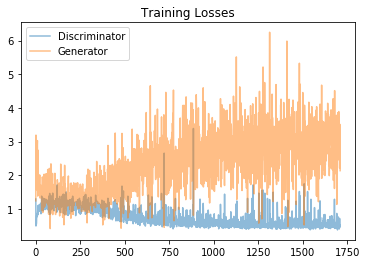

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

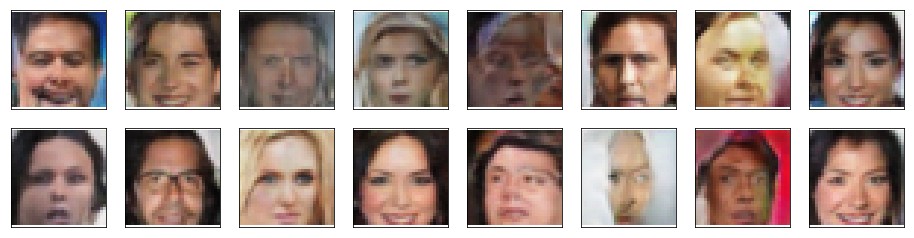

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** Overall the model performs pretty well. I noticed that faces have higher color contrast from background color tends to yield clearer images. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.